### Develop analyses to look at weights of pseudo population decoders

In [9]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import scipy.stats
from lfp_tools import (
    general as lfp_general,
    startup as lfp_startup,
    development as lfp_development,
    analysis as lfp_analysis
)
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
import s3fs
import utils.behavioral_utils as behavioral_utils
import utils.spike_utils as spike_utils
import utils.classifier_utils as classifier_utils
import utils.visualization_utils as visualization_utils
import utils.io_utils as io_utils
import utils.pseudo_utils as pseudo_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils

from utils.session_data import SessionData
from trial_splitters.random_splitter import RandomSplitter
from trial_splitters.block_splitter import BlockSplitter
from trial_splitters.kfold_splitter import KFoldSplitter
from trial_splitters.rule_condition_block_splitter import RuleConditionBlockSplitter
from trial_splitters.condition_trial_splitter import ConditionTrialSplitter
from trial_splitters.dummy_pseudo_splitter import DummyPseudoSplitter
from trial_splitters.condition_kfold_block_splitter import ConditionKFoldBlockSplitter

from models.value_models import ValueNormedModel, ValueNormedDropoutModel
import pickle

from models.multinomial_logistic_regressor import NormedDropoutMultinomialLogisticRegressor
from models.model_wrapper import ModelWrapper, ModelWrapperLinearRegression

from models.trainer import Trainer
from sklearn.cluster import KMeans

import torch
from torch import nn

import plotly.express as px
import matplotlib.patches as patches

import scipy.stats as sci_stats
import scipy

from itertools import accumulate

session = 20180802  # this is the session for which there are spikes at the moment. 

feature_dims = ["Color", "Shape", "Pattern"]

pre_interval = 1300
post_interval = 1500

import os
import json

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Look at positions of all the neurons first, group and color by level 1 structure, plot without and with unidentified neurons. 

In [15]:
def get_neuron_positions(row):
    session = row.session_name
    # For the cases like 201807250001
    sess_day = session[:8]
    info_path = f"/data/rawdata/sub-SA/sess-{sess_day}/session_info/sub-SA_sess-{sess_day}_sessioninfo.json"
    with open(info_path, 'r') as f:
        data = json.load(f)
    locs = data['electrode_info']
    locs_df = pd.DataFrame.from_dict(locs)
    # TODO: filter by units appearing in firing rates file. 
    electrode_pos_not_nan = locs_df[~locs_df['x'].isna() & ~locs_df['y'].isna() & ~locs_df['z'].isna()]
    units = spike_general.list_session_units(None, "SA", session, species_dir="/data")
    unit_pos = pd.merge(units, electrode_pos_not_nan, left_on="Channel", right_on="electrode_id", how="left")
    unit_pos = unit_pos.astype({"UnitID": int})
    unit_pos["session"] = session
    return unit_pos

valid_sess = pd.read_pickle("/data/patrick_scratch/multi_sess/valid_sessions.pickle")
positions = pd.concat(valid_sess.apply(get_neuron_positions, axis=1).values)

In [16]:
positions.Unit

,UnitID,Channel,Unit,SpikeTimesFile,electrode_id,x,y,z,distance,in_brain,tissue,structure_level1,structure_level2,structure_level3,structure_level4,structure_level5,structure_level6,structure_potential,session
0,0,31,1,/data/rawdata/sub-SA/sess-20180709/spikes/sub-...,31,4.231776,-73.619593,1.559706,8.75000,True,Cortical_gray_matter,Parietal_Lobe (Parietal),posterior_medial_cortex (PMC),posterior_cingulate_gyrus (PCgG),posterior_cingulate_cortex (PCC),area_23 (area_23),area_23c (area_23c),None,20180709
1,1,89a,1,/data/rawdata/sub-SA/sess-20180709/spikes/sub-...,89a,2.354436,-75.892485,29.306235,10.56250,True,Cortical_gray_matter,Frontal_Lobe (Frontal),motor_cortex (motor),medial_supplementary_motor_areas (SMA/preSMA),medial_supplementary_motor_areas (SMA/preSMA),presupplementary_motor_area (preSMA),presupplementary_motor_area (preSMA),None,20180709
2,2,42a,1,/data/rawdata/sub-SA/sess-20180709/spikes/sub-...,42a,11.622132,-70.948350,36.590204,7.50000,True,White_matter,None,None,None,None,None,None,None,20180709
3,3,8a,1,/data/rawdata/sub-SA/sess-20180709/spikes/sub-...,8a,-0.342060,-76.335619,39.109245,8.50000,True,Cortical_gray_matter,Frontal_Lobe (Frontal),lateral_prefrontal_cortex (lat_PFC),dorsolateral_prefrontal_cortex (dlPFC),area_8B (area_8B),area_8B (area_8B),medial_area_8B (area_8Bm),dlPFC,20180709
4,4,95a,1,/data/rawdata/sub-SA/sess-20180709/spikes/sub-...,95a,2.062497,-78.563568,28.864301,8.12500,True,White_matter,None,None,None,None,None,None,None,20180709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,25,25a,1,/data/rawdata/sub-SA/sess-20180910/spikes/sub-...,25a,4.793843,-73.980388,40.538300,7.62500,True,Cortical_gray_matter,Frontal_Lobe (Frontal),lateral_prefrontal_cortex (lat_PFC),dorsolateral_prefrontal_cortex (dlPFC),rostral_dorsolateral_prefrontal_cortex (rostra...,dorsal_area_46 (area_46d),dorsal_area_46 (area_46d),dlPFC,20180910
26,26,39a,1,/data/rawdata/sub-SA/sess-20180910/spikes/sub-...,39a,11.623372,-69.652737,37.916912,7.75000,True,Cortical_gray_matter,Frontal_Lobe (Frontal),orbital_frontal_cortex (OFC),lateral_orbital_frontal_cortex (lat_OFC),medial_and_orbital_area_12 (area_12m/o),medial_and_orbital_area_12 (area_12m/o),medial_area_12 (area_12m),None,20180910
27,27,23,1,/data/rawdata/sub-SA/sess-20180910/spikes/sub-...,23,4.223423,-70.308308,1.052348,11.90625,True,Cortical_gray_matter,Parietal_Lobe (Parietal),superior_parietal_lobule (SPL),area_5 (area_5),area_5 (area_5),area_PEa (PEa),area_PEa (PEa),None,20180910
28,28,28a,2,/data/rawdata/sub-SA/sess-20180910/spikes/sub-...,28a,5.568581,-73.424981,41.715624,7.12500,True,Cortical_gray_matter,Frontal_Lobe (Frontal),lateral_prefrontal_cortex (lat_PFC),dorsolateral_prefrontal_cortex (dlPFC),rostral_dorsolateral_prefrontal_cortex (rostra...,dorsal_area_46 (area_46d),dorsal_area_46 (area_46d),dlPFC,20180910


### See if plotting weights makes sense here

In [2]:
# load some models
base_dir = "/data/patrick_scratch/pseudo"
feature_dim = "Pattern"
models = np.load(os.path.join(base_dir, f"{feature_dim}_models.npy"), allow_pickle=True)

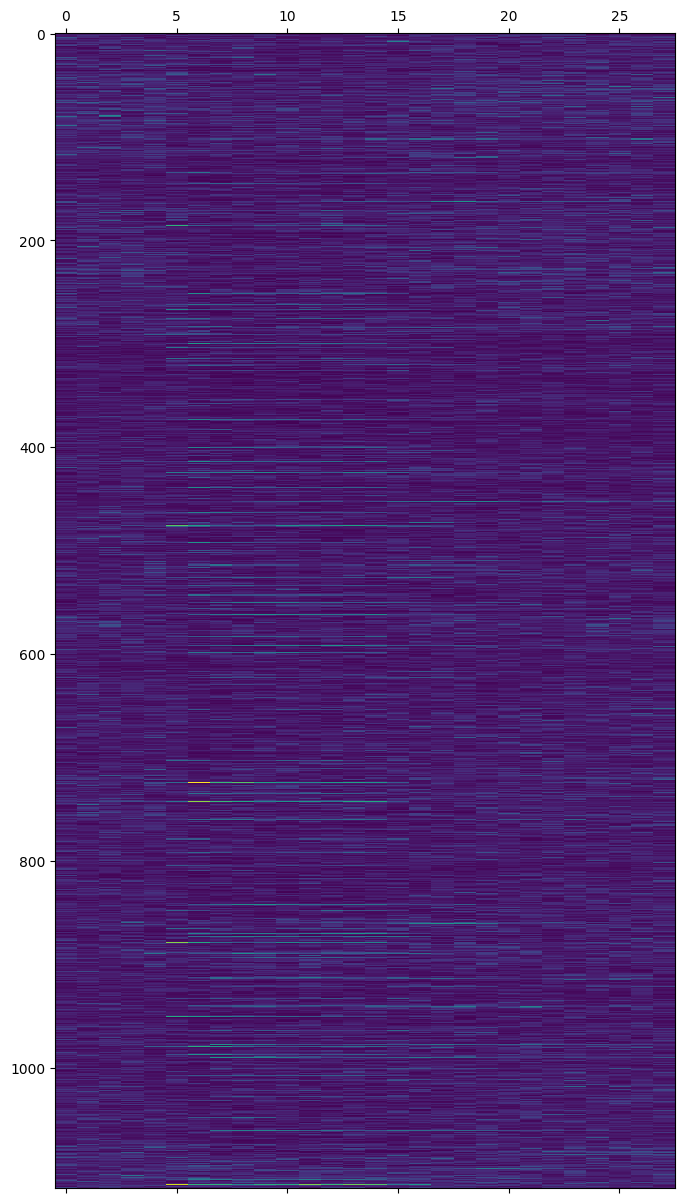

In [7]:
weights = classifier_utils.evaluate_model_weights_by_time_bins(models, 1117, 4)
sums = np.sum(weights, axis=0)
normalized = weights / sums

# # reorder by temp then ant
# reordered = normalized[reordered_units, :]


fig, ax = plt.subplots(figsize=(8, 15))
colors = ax.matshow(normalized, aspect='auto')

In [6]:
models[0][0].coef_.shape

(4, 1117)

In [12]:
weights.shape

(1117, 28)